In [1]:
# load necessary libraries
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

import json
import pickle
import glob

from readImages import *
from imageModifiers import *
from readDataFiles import *
from projEdgeBreaks import *
from gaussBreaks import *
from saveImages import *
from plottingFuncs import *

# change pandas parameter
pd.options.mode.chained_assignment = None
# change plot size
mpl.rcParams["figure.figsize"] = (15, 15)

## Read data files
Subject file, classification export, and data from experiment

In [2]:
subjFile = "data/decoding-the-civil-war-subjects-9-29-17.csv"
clFile = 'data/letter-slope-classifications_10nov2017.csv'
experimentFile = "accuracy.pkl"

consensusFolder = "C:/Users/danny/Repos/text_segmentation/consensus/consensus/"
# consensusFile = consensusFolder + "decoding-the-civil-war-consensus-linewise_{mss_label}.csv"
consensusCsvFiles = glob.glob('{}/*.csv'.format(consensusFolder))
consensusCsvFiles = [i for i in consensusCsvFiles if "linewise" in i]

# subject file
subj = readSubjFile(subjFile)
# classification export
clExp = readSlopeClassification(clFile)

# experiment data
with open(experimentFile, "rb") as f:
    data = pickle.load(f)

Define a couple functions for analysis

In [3]:
# seg the segments associated with a nu and biThresh value
def getSegments(segments, nu, biThresh):
    bi2 = list(segments['biThresh'] == biThresh)
    nu2 = list(segments['nu'] == nu)
    getm = [bi2[i] and nu2[i] for i in range(len(segments))]
    return segments.loc[getm]

# plot the best segmentation
def plotBest(let, cur_data, best_segments):
    lb = np.add(cur_data['lb'], cur_data['trim_offset'][0])[list(best_segments['lb_index'])]
    lb = np.insert(lb, 0, cur_data['trim_offset'][0])

    xoff = cur_data['trim_offset'][1]
    wb = [i+xoff for i in best_segments.loc[:,'breaks']]
    plotBoxes(let, lb, wb)

Get the errors on the parameters I tested

In [4]:
errors = {}

for hdl_id in data.keys():
    # get data for current hdl_id
    cur_data = data[hdl_id]
    segments = cur_data["segment_results"]

    # add more info to segments data
    n_words_gauss = segments.loc[:,'n_words_gauss']-1
    n_words_cons = segments.loc[:,'n_words_cons']
    segments.loc[:,'word_diff'] = n_words_gauss - n_words_cons
    segments.loc[:,'word_diff_abs'] = np.abs(n_words_gauss - n_words_cons)

    grouped = segments.groupby(['nu', 'biThresh'])[['word_diff_abs', 'word_diff']]
    error = grouped.mean().reset_index()
    errors[hdl_id] = error
    
    # print best
    bestrow = error.loc[error['word_diff_abs'].idxmin()]
    st = 'hdl_id: {0}, nu: {1}, biThresh: {2},\n\terror: {3}, segment diff: {4}'
    print(st.format(hdl_id, bestrow['nu'], bestrow['biThresh'],
                    bestrow['word_diff_abs'], bestrow['word_diff']))


# get total error for all images
tot_error = errors['mssEC_02_007'].copy()
for k, v in errors.items():
    if k == 'mssEC_02_007':
        next
    else:
        tot_error['word_diff_abs'] += v['word_diff_abs']
sorted_error = tot_error.sort_values('word_diff_abs')
best_params = sorted_error.iloc[0].loc[['nu', 'biThresh']]

hdl_id: mssEC_02_007, nu: 3.0, biThresh: 8.0,
	error: 0.625, segment diff: 0.4375
hdl_id: mssEC_02_032, nu: 3.0, biThresh: 4.0,
	error: 0.5151515151515151, segment diff: 0.45454545454545453
hdl_id: mssEC_02_131, nu: 2.5, biThresh: 5.0,
	error: 0.2857142857142857, segment diff: -0.11428571428571428
hdl_id: mssEC_02_175, nu: 2.5, biThresh: 8.0,
	error: 0.5, segment diff: 0.125
hdl_id: mssEC_04_089, nu: 2.5, biThresh: 5.0,
	error: 1.4444444444444444, segment diff: -1.0555555555555556
hdl_id: mssEC_11_085, nu: 2.0, biThresh: 4.0,
	error: 0.875, segment diff: -0.041666666666666664
hdl_id: mssEC_11_092, nu: 3.0, biThresh: 2.0,
	error: 1.68, segment diff: -0.56
hdl_id: mssEC_11_120, nu: 3.0, biThresh: 1.0,
	error: 0.8846153846153846, segment diff: 0.8846153846153846
hdl_id: mssEC_11_194, nu: 1.5, biThresh: 9.0,
	error: 0.8076923076923077, segment diff: -0.5769230769230769
hdl_id: mssEC_11_386, nu: 4.0, biThresh: 1.0,
	error: 1.1578947368421053, segment diff: 0.21052631578947367
hdl_id: mssEC_

In [5]:
sorted_error.iloc[0:10]

,nu,biThresh,word_diff_abs,word_diff
55,3.5,2,13.848896,1.00000
47,3.0,3,14.048205,1.03125
73,4.5,2,14.280581,1.00000
82,5.0,2,14.328737,0.87500
56,3.5,3,14.338617,0.93750
39,2.5,4,14.464341,0.96875
64,4.0,2,14.527605,1.03125
40,2.5,5,14.569063,0.90625
48,3.0,4,14.570310,0.87500
72,4.5,1,14.589410,1.15625


Plot segmentation for an hdl_id

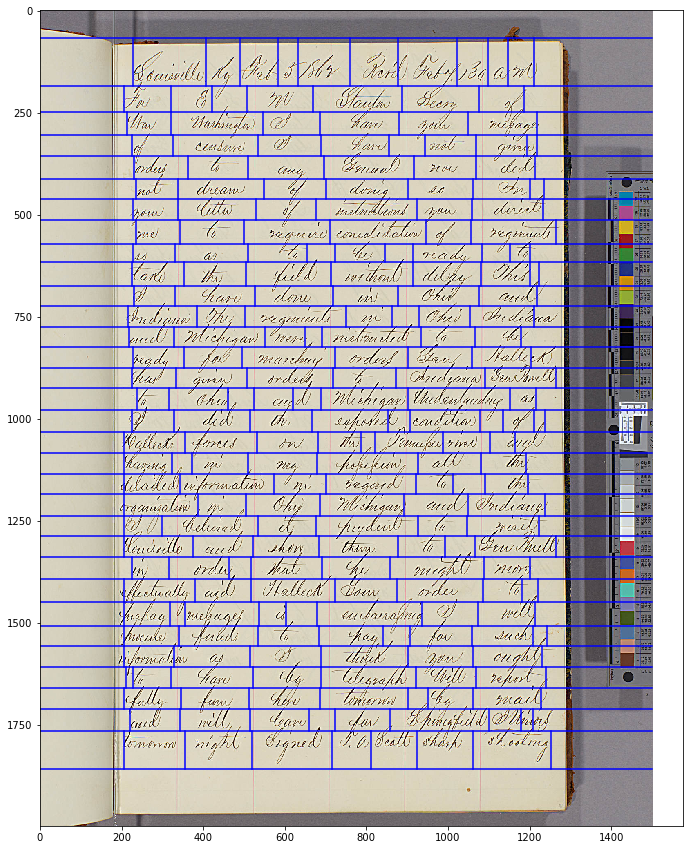

In [8]:
hdl_id = 'mssEC_02_007'
# read images
url = subj.iloc[np.where(subj["hdl_id"] == hdl_id)[0][0]]["url"]
let, grey = readImg(url)
cur_data = data[hdl_id]
best = getSegments(cur_data['segment_results'], bestrow['nu'],
                    bestrow['biThresh'])
plotBest(let, cur_data, best)